In [1]:
#importing required libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#importing sklearn libraries
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

from numpy import interp
from itertools import cycle

In [2]:
#directory path for full dataset
imagedir ="/home/sanjeev/DL_POC/MlaImg_Data/Malimg_data/"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
vgg16 = np.load("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/vgg16_finetuned_feat_malimg_256.npy")
vgg19 = np.load("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/vgg19_feat_malimg_256.npy")
res = np.load("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/resnet50_feat_malimg_256.npy")
incv3 = np.load("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/inceptionV3_feat_malimg_256.npy")

In [5]:
X = []
for i in range(len(vgg16)):
    x = list(np.hstack((vgg16[i], vgg19[i], res[i], incv3[i])))
    X.append(x)

In [6]:
# X

In [7]:
X =  np.array(X)
X.shape

(9339, 1024)

In [8]:
label = np.array(y)
label.shape

(9339,)

In [10]:
cor_mat = pd.DataFrame(X).corr()
cor_mat.shape

(1024, 1024)

In [11]:
li = []
for i in range(1024):
    for j in range(1024):
        if i == j:
            pass
        else:
            if cor_mat[i][j] > 0.9:
                li.append([i, j])

In [12]:
lis_11 = [i[0] for i in li]
lis_22 = [i[1] for i in li]

In [13]:
x = sorted(list(set(lis_11)))
y = sorted(list(set(lis_22)))
x == y

True

#### Removal of most correlated features

In [19]:
s = {x for l in li for x in l}
len(s)

39

In [20]:
arr = X
arr = np.delete(arr, list(s), axis=1)
print(arr.shape)

(9339, 985)


In [21]:
# !pip install optuna

In [22]:
import optuna

In [23]:
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)

    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int('n_units {}'.format(i), 1, 128))

    clf = MLPClassifier(tuple(layers))
    x_train, x_test, y_train, y_test = train_test_split(arr, label, test_size=0.20, random_state=31)

    clf.fit(x_train, y_train)
    return 1.0 - clf.score(x_test, y_test)

In [24]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2022-10-26 17:47:21,948] A new study created in memory with name: no-name-e8bc1022-da65-4563-8f33-12e66985bc38
[I 2022-10-26 17:47:37,431] Trial 0 finished with value: 0.9823340471092077 and parameters: {'n_layers': 4, 'n_units 0': 92, 'n_units 1': 26, 'n_units 2': 82, 'n_units 3': 64}. Best is trial 0 with value: 0.9823340471092077.
[I 2022-10-26 17:47:52,873] Trial 1 finished with value: 0.9839400428265525 and parameters: {'n_layers': 4, 'n_units 0': 125, 'n_units 1': 43, 'n_units 2': 83, 'n_units 3': 40}. Best is trial 0 with value: 0.9823340471092077.
[I 2022-10-26 17:48:02,175] Trial 2 finished with value: 0.9823340471092077 and parameters: {'n_layers': 1, 'n_units 0': 36}. Best is trial 0 with value: 0.9823340471092077.
[I 2022-10-26 17:48:16,798] Trial 3 finished with value: 0.9817987152034261 and parameters: {'n_layers': 4, 'n_units 0': 59, 'n_units 1': 90, 'n_units 2': 104, 'n_units 3': 106}. Best is trial 3 with value: 0.9817987152034261.
[I 2022-10-26 17:48:55,034] Trial 

[I 2022-10-26 17:57:26,736] Trial 35 finished with value: 0.9796573875802997 and parameters: {'n_layers': 3, 'n_units 0': 23, 'n_units 1': 97, 'n_units 2': 71}. Best is trial 10 with value: 0.3404710920770878.
/home/sanjeev/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[I 2022-10-26 17:57:41,158] Trial 36 finished with value: 0.9518201284796574 and parameters: {'n_layers': 2, 'n_units 0': 7, 'n_units 1': 27}. Best is trial 10 with value: 0.3404710920770878.
[I 2022-10-26 17:57:49,626] Trial 37 finished with value: 0.9823340471092077 and parameters: {'n_layers': 4, 'n_units 0': 33, 'n_units 1': 49, 'n_units 2': 22, 'n_units 3': 88}. Best is trial 10 with value: 0.3404710920770878.
/home/sanjeev/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

/home/sanjeev/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[I 2022-10-26 18:10:02,145] Trial 66 finished with value: 0.8752676659528907 and parameters: {'n_layers': 4, 'n_units 0': 50, 'n_units 1': 68, 'n_units 2': 9, 'n_units 3': 3}. Best is trial 10 with value: 0.3404710920770878.
[I 2022-10-26 18:10:16,123] Trial 67 finished with value: 0.9823340471092077 and parameters: {'n_layers': 2, 'n_units 0': 73, 'n_units 1': 56}. Best is trial 10 with value: 0.3404710920770878.
[I 2022-10-26 18:10:28,100] Trial 68 finished with value: 0.9834047109207709 and parameters: {'n_layers': 3, 'n_units 0': 60, 'n_units 1': 47, 'n_units 2': 11}. Best is trial 10 with value: 0.3404710920770878.
[I 2022-10-26 18:10:38,034] Trial 69 finished with value: 0.9812633832976445 and parameters: {'n_layers': 3, 'n_units 0': 29, 

[I 2022-10-26 18:21:34,495] Trial 95 finished with value: 0.9550321199143469 and parameters: {'n_layers': 3, 'n_units 0': 6, 'n_units 1': 3, 'n_units 2': 23}. Best is trial 10 with value: 0.3404710920770878.
[I 2022-10-26 18:21:49,995] Trial 96 finished with value: 0.9812633832976445 and parameters: {'n_layers': 3, 'n_units 0': 22, 'n_units 1': 109, 'n_units 2': 13}. Best is trial 10 with value: 0.3404710920770878.
[I 2022-10-26 18:22:01,833] Trial 97 finished with value: 0.9807280513918629 and parameters: {'n_layers': 2, 'n_units 0': 13, 'n_units 1': 8}. Best is trial 10 with value: 0.3404710920770878.
/home/sanjeev/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[I 2022-10-26 18:22:30,177] Trial 98 finished with value: 0.5952890792291221 and parameters: {'n_layers': 3, 'n_units 0': 2, 'n_units 1': 14, '

CPU times: user 9h 32min 5s, sys: 12h 16min 31s, total: 21h 48min 36s
Wall time: 35min 52s


In [84]:
X_train, X_test, y_train, y_test = train_test_split(arr, label, test_size=0.20, random_state=31)

In [68]:
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)
print("y_train shape =", y_train.shape)
print("y_test shape =", y_test.shape)

X_train shape = (7471, 985)
X_test shape = (1868, 985)
y_train shape = (7471,)
y_test shape = (1868,)


In [30]:
%%time
clf = MLPClassifier(random_state=31, max_iter=500, hidden_layer_sizes=(96,))
clf.fit(X_train, y_train)

CPU times: user 4min 23s, sys: 4min 21s, total: 8min 45s
Wall time: 13.5 s


MLPClassifier(hidden_layer_sizes=(96,), max_iter=500, random_state=31)

In [85]:
%%time
clf = MLPClassifier(random_state=31, max_iter=500, hidden_layer_sizes=(1, 119, 3))
clf.fit(X_train, y_train)

CPU times: user 17min 2s, sys: 33min 10s, total: 50min 12s
Wall time: 1min 47s


MLPClassifier(hidden_layer_sizes=(1, 119, 3), max_iter=500, random_state=31)

In [86]:
print("Training Accuracy:", round((clf.score(X_train, y_train) * 100), 2))

Training Accuracy: 64.21


In [87]:
print("Testing Accuracy:", round((clf.score(X_test, y_test) * 100), 2))

Testing Accuracy: 62.31


In [50]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 314 ms, sys: 0 ns, total: 314 ms
Wall time: 14.2 ms


In [51]:
%%time
ls = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(int(round(ls[0]*100, 0)), int(round(ls[1]*100, 0)), int(round(ls[2]*100, 0)))

98 98 98
CPU times: user 3.26 ms, sys: 4.13 ms, total: 7.39 ms
Wall time: 6.26 ms


In [53]:
%%time
score = cross_val_score(clf, X, label, cv=5)
round(np.mean(score)*100, 2)

CPU times: user 13min 37s, sys: 10min 7s, total: 23min 44s
Wall time: 38.7 s


98.22

Plotting the confusion matrix


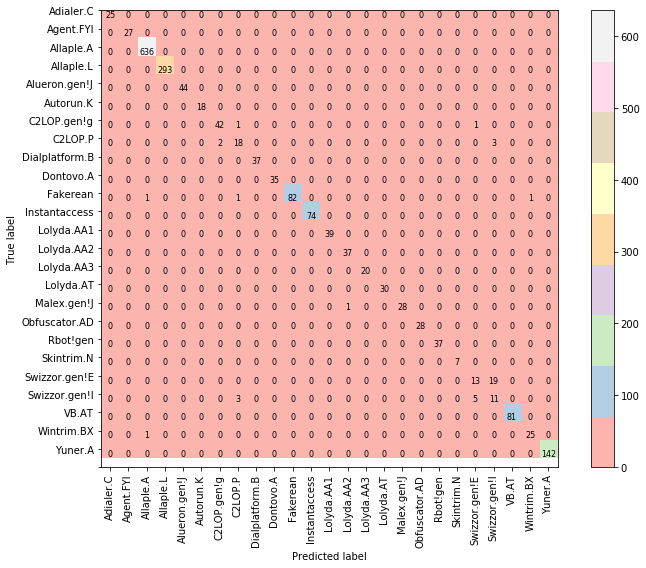

In [54]:
conf_matrix = confusion_matrix(y_test, y_pred)

print("Plotting the confusion matrix")
conf_mat = np.around(conf_matrix, decimals=2)  
figure = plt.gcf()
figure.set_size_inches(10, 8)
plt.imshow(conf_mat, interpolation='nearest', cmap='Pastel1')

for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]), xy=(col,row), ha='center', va='top', fontsize=8)
        
plt.xticks(range(len(list_fams)), list_fams, rotation=90, fontsize=10)
plt.yticks(range(len(list_fams)+1), list_fams, fontsize=10)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.tight_layout()
plt.colorbar()
# plt.savefig("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/Plots_malimg/Finetuned_plots/mlp_cm_corr.eps", bbox_inches='tight')
# plt.savefig("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/Plots_malimg/Finetuned_plots/mlp_cm_corr.png", bbox_inches='tight')

plt.show()

In [55]:
classification_metrices = metrics.classification_report(y_test, y_pred, target_names=list_fams)
print(classification_metrices)

                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        25
     Agent.FYI       1.00      1.00      1.00        27
     Allaple.A       1.00      1.00      1.00       636
     Allaple.L       1.00      1.00      1.00       293
 Alueron.gen!J       1.00      1.00      1.00        44
     Autorun.K       1.00      1.00      1.00        18
   C2LOP.gen!g       0.95      0.95      0.95        44
       C2LOP.P       0.78      0.78      0.78        23
Dialplatform.B       1.00      1.00      1.00        37
     Dontovo.A       1.00      1.00      1.00        35
      Fakerean       1.00      0.96      0.98        85
 Instantaccess       1.00      1.00      1.00        74
    Lolyda.AA1       1.00      1.00      1.00        39
    Lolyda.AA2       0.97      1.00      0.99        37
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       1.00      1.00      1.00        30
   Malex.gen!J       1.00      0.97      0.98  

In [26]:
# classification_metrices = metrics.classification_report(y_test, y_pred, output_dict=True, target_names= list_fams)
# df = pd.DataFrame(classification_metrices).transpose()
# df.to_csv('/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/Plots_malimg/Finetuned_plots/mlp_cr_corr.csv')

In [56]:
print("micro_precision :", metrics.precision_score(y_test, y_pred, average='micro'))
print("micro_recall :", metrics.recall_score(y_test, y_pred, average='micro'))
print("micro_f1_score :", metrics.f1_score(y_test, y_pred, average='micro'))

micro_precision : 0.9791220556745182
micro_recall : 0.9791220556745182
micro_f1_score : 0.9791220556745182


In [57]:
print("macro_precision :", metrics.precision_score(y_test, y_pred, average='macro'))
print("macro_recall :", metrics.recall_score(y_test, y_pred, average='macro'))
print("macro_f1_score :", metrics.f1_score(y_test, y_pred, average='macro'))

macro_precision : 0.9474714354269314
macro_recall : 0.9445645241555758
macro_f1_score : 0.9432464933132073


In [58]:
print("weighted_precision :", metrics.precision_score(y_test, y_pred, average='weighted'))
print("weighted_recall :", metrics.recall_score(y_test, y_pred, average='weighted'))
print("weighted_f1_score :", metrics.f1_score(y_test, y_pred, average='weighted'))

weighted_precision : 0.9819382524397156
weighted_recall : 0.9791220556745182
weighted_f1_score : 0.9795635468503364


In [70]:
y_test = y_test.toarray()
y_pred = y_pred.toarray()

In [71]:
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))  
y_test = enc.transform(y_test.reshape(-1, 1))
y_pred = enc.transform(y_pred.reshape(-1, 1))

In [76]:
y_test = y_test.toarray()
y_pred = y_pred.toarray()

In [77]:
n_classes = 25

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/home/sanjeev/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/home/sanjeev/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/home/sanjeev/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/home/sanjeev/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/home/sanjeev/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value sho

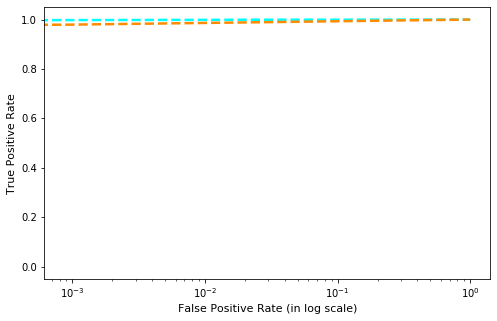

In [78]:
# Compute macro-average ROC curve and ROC area

n_classes = 25
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2.5   # line width
plt.figure(figsize=(8,5))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'green', 'red', 'cyan', 'blue', 
                 'pink', 'purple', 'brown', 'coral', 'chocolate', 'indigo', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='dashed', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.xscale("log")
plt.xlabel('False Positive Rate (in log scale)', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
# plt.savefig("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/Plots_malimg/Finetuned_plots/mlp_roc_corr.eps", bbox_inches='tight')
# plt.savefig("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/Plots_malimg/Finetuned_plots/mlp_roc_corr.png", bbox_inches='tight')

plt.show()